In [1]:
import os
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basedir = "/home/pcktm/inzynierka/kitti/dataset"

In [3]:
test_dataset = KittiGraphDataset(basedir, "09", graph_length=8)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [64]:
checkpoint = torch.load(
    "./models/LOSS_TEST_B_VECTORIZED_BATCH1/model_40.pth", map_location=device
)

model = PoseGNN()
model.load_state_dict(checkpoint)
model.to(device)

PoseGNN(
  (conv1): GraphConv(2048, 256)
  (conv2): GraphConv(256, 128)
  (conv3): GraphConv(128, 64)
  (position): Linear(in_features=64, out_features=3, bias=True)
  (orientation): Linear(in_features=64, out_features=4, bias=True)
)

In [65]:
SELECTED_IDX = -1

predicted_poses = []
true_poses = []
shifts = []

model.eval()

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.to(device)
        output = model(batch).cpu().numpy()
        # get shift between last and second to last graph node
        last = output[-1]
        second_to_last = output[-2]
        shift = last - second_to_last
        shifts.append(shift)
        true_poses.append(batch.y.cpu().numpy()[SELECTED_IDX])
        predicted_poses.append(output[SELECTED_IDX])

  0%|          | 0/1583 [00:00<?, ?it/s]

100%|██████████| 1583/1583 [00:03<00:00, 417.38it/s]


In [47]:
print(shifts)

[array([-3.1113625e-05,  6.0722232e-05, -4.1723251e-05, -1.1920929e-07,
       -5.9604645e-08,  1.4901161e-07,  2.0116568e-07], dtype=float32), array([ 1.8835068e-05, -3.3266842e-05,  2.3841858e-05,  0.0000000e+00,
        0.0000000e+00, -1.4901161e-07, -9.6857548e-08], dtype=float32), array([ 2.1815300e-05, -3.4995377e-05,  2.7418137e-05,  2.9802322e-08,
        5.9604645e-08, -8.9406967e-08, -8.9406967e-08], dtype=float32), array([-1.8954277e-05,  4.6052039e-05, -2.5987625e-05, -8.9406967e-08,
       -5.9604645e-08,  1.1920929e-07,  1.4156103e-07], dtype=float32), array([-5.1259995e-06, -1.3485551e-06, -4.5299530e-06, -2.9802322e-08,
        5.9604645e-08,  0.0000000e+00, -1.4901161e-08], dtype=float32), array([ 9.5367432e-07, -1.3329089e-05,  3.0994415e-06,  0.0000000e+00,
        0.0000000e+00, -2.9802322e-08, -3.7252903e-08], dtype=float32), array([ 1.7642975e-05, -2.3849308e-05,  2.1934509e-05,  2.9802322e-08,
       -5.9604645e-08, -5.9604645e-08, -5.2154064e-08], dtype=float32)

In [51]:
def tensor_to_position_and_rotation(tensor):
    pos = tensor[:3]
    rot = tensor[3:]
    # rot = R.from_quat(rot)
    return {
        "position": pos,
        # "rotation": rot,
    }

[ 1.4256201   0.02210128  1.283582   -0.4892738  -0.7635781  -0.41070494
  0.09423963]
[ 1.4284182   0.02222065  1.2861817  -0.48927358 -0.76357836 -0.4107048
  0.09423961]
[ 1.4240342   0.02199598  1.282124   -0.48927355 -0.76357883 -0.41070357
  0.09424022]
[ 1.4239393   0.02194304  1.2820868  -0.48927358 -0.76357836 -0.41070488
  0.09423926]
[ 1.4248694   0.02203926  1.2828879  -0.4892735  -0.76357925 -0.41070294
  0.09424055]
[ 1.4225556   0.02187398  1.2807531  -0.48927364 -0.7635786  -0.4107042
  0.09423961]
[ 1.4229918   0.02188857  1.2811427  -0.48927346 -0.7635792  -0.41070306
  0.09424023]
[ 1.4223019   0.02182703  1.2804971  -0.4892735  -0.7635788  -0.41070402
  0.09423959]
[ 1.4245893   0.02190714  1.2826018  -0.48927364 -0.76357824 -0.4107049
  0.09423923]
[ 1.4279323   0.02221273  1.2856402  -0.4892736  -0.7635785  -0.4107043
  0.09423977]
[ 1.4284002   0.02217451  1.2860789  -0.48927373 -0.76357853 -0.4107042
  0.09424007]
[ 1.4318272   0.02231991  1.2892637  -0.4892737 

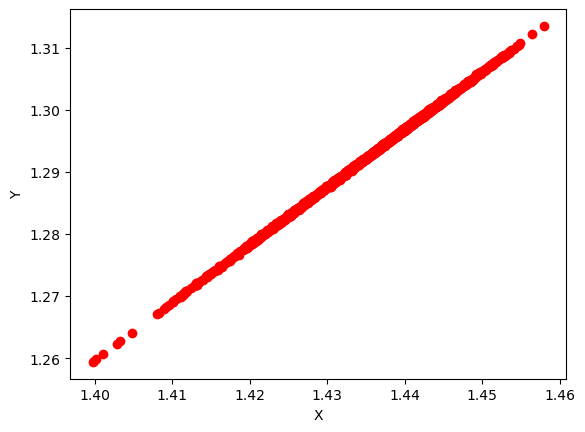

In [44]:
predicted_poses_e = [tensor_to_position_and_rotation(pose) for pose in predicted_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Y')

for pose in predicted_poses_e:
  ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

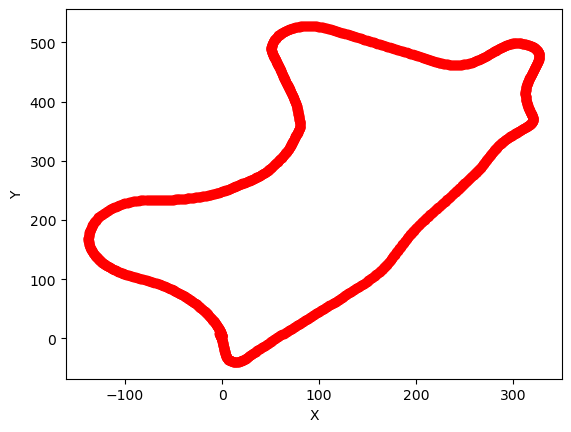

In [29]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

# plot predicted poses
ax = plt.axes()
ax.set_xlabel("X")
ax.set_ylabel("Y")

for pose in true_poses_e:
    ax.scatter(pose["position"][0], pose["position"][2], c="r")

plt.show()

In [20]:
print(shifts[0])

[-3.1113625e-05  6.1206520e-05 -4.1723251e-05 -1.1920929e-07
 -5.9604645e-08  1.4901161e-07  2.0116568e-07]


In [66]:
def odometry_predicted_poses(predictions):
  """
  predictions: list of predictions

  This function adds the predictions of shifts to the previous position and rotation, 
  returing the absolute position and rotation.
  """
  predictions = [tensor_to_position_and_rotation(prediction) for prediction in predictions]
  world_positions = []
  world_rotations = []

  world_positions.append(predictions[0]["position"])

  for i, prediction in enumerate(predictions[1:]):
    world_positions.append(world_positions[i-1] + prediction["position"])
    print(f"Accumulated position: {world_positions[i-1]}")
    # now, rotations are in quaternion form so use appropriate function
    # world_rotations.append(world_rotations[i-1] * prediction["rotation"])

  # return [{"position": pos, "rotation": rot} for pos, rot in zip(world_positions, world_rotations)]
  return [{"position": pos} for pos in world_positions]
  return [
    {
      "position": pos,
      "rotation": rot.as_quat(),
    }
    for pos, rot in zip(world_positions, world_rotations)
  ]

Accumulated position: [ 6.556511e-07 -3.874302e-07 -8.940697e-08]
Accumulated position: [ 4.1723251e-07 -1.4901161e-07  7.4505806e-08]
Accumulated position: [ 6.556511e-07 -3.874302e-07 -8.940697e-08]
Accumulated position: [ 1.4901161e-07 -7.4505806e-08 -4.4703484e-08]
Accumulated position: [ 3.8743019e-07 -1.3411045e-07  1.7881393e-07]
Accumulated position: [ 2.8312206e-07 -1.0430813e-07 -4.4703484e-08]
Accumulated position: [ 5.6624413e-07 -1.8626451e-07  0.0000000e+00]
Accumulated position: [ 3.2782555e-07 -3.7997961e-07 -1.9371510e-07]
Accumulated position: [ 4.6193600e-07 -2.0116568e-07 -2.9802322e-08]
Accumulated position: [ 2.9802322e-07 -2.9057264e-07 -2.0861626e-07]
Accumulated position: [ 5.5134296e-07 -2.0116568e-07 -4.4703484e-08]
Accumulated position: [ 1.9371510e-07 -1.7881393e-07 -7.4505806e-08]
Accumulated position: [ 6.2584877e-07 -5.7369471e-07 -2.3841858e-07]
Accumulated position: [ 2.5331974e-07 -2.6822090e-07 -1.4901161e-07]
Accumulated position: [ 7.1525574e-07 -3

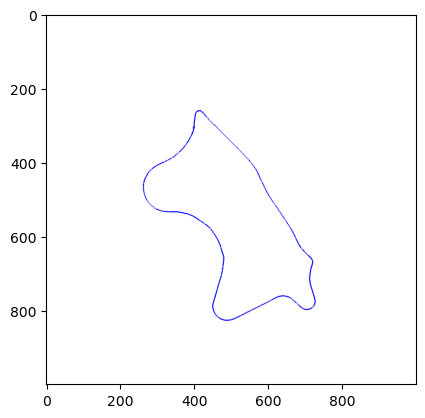

In [67]:
true_poses_e = [tensor_to_position_and_rotation(pose) for pose in true_poses]

trajectory_image = np.zeros((1000, 1000, 3), dtype=np.uint8)
trajectory_image.fill(255)

predicted_world_poses = odometry_predicted_poses(shifts)

for i in range(len(predicted_world_poses)):
    pos = predicted_world_poses[i]["position"]
    x = int(pos[0]) + 400
    y = int(pos[2]) + 300

    gt_x = int(true_poses_e[i]["position"][0]) + 400
    gt_y = int(true_poses_e[i]["position"][2]) + 300

    cv2.circle(trajectory_image, (gt_x, gt_y), 1, (255, 0, 0), 1)
    cv2.circle(trajectory_image, (x, y), 1, (0, 0, 255), 1)


trajectory_image = cv2.cvtColor(trajectory_image, cv2.COLOR_BGR2RGB)
plt.imshow(trajectory_image)